# Example: Computer vision pipeline Minimum Viable Product (MVP)

In [ ]:
# Dependencies and libraries
import cv2, torch     # Computer vision stuffs
from tqdm import tqdm # Nice progress bar

!pip install ultralytics --quiet # Lets us use the pre-trained YOLO model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.5 MB/s eta 0:00:00


In [ ]:
# Download data
!curl -L -o './INT-quad-data.mp4' 'https://raw.githubusercontent.com/PurdueAerialRoboticsTeam/PART-2025-SW-Exploration-Session/refs/heads/main/data/INT-quad-data.mp4'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 86.9M  100 86.9M    0     0  27.8M      0  0:00:03  0:00:03 --:--:-- 27.8M


In [ ]:
# Load pre-trained YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

/usr/local/lib/python3.12/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2025-9-2 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 162MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [ ]:
# I sure hope you're running on a GPU
# - If not, switch to a GPU runtime by going to the topbar and
#   select `Runtime` > `Change runtime type` > `T4 GPU`. Then rerun everything
print(f"GPU? {torch.cuda.is_available()}")
print(f"GPU Name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

GPU? True
GPU Name: Tesla T4


In [ ]:
# Read in quad capture
cap = cv2.VideoCapture('INT-quad-data.mp4')

# Prepare output video
out = cv2.VideoWriter(
  'output.mp4',                    # Output filename
  cv2.VideoWriter_fourcc(*'mp4v'), # Four Character Codec `mp4v`
  int(cap.get(5)),   # Gets property 5 `cv2.CAP_PROP_FPS`
  (
    int(cap.get(3)), # Gets property 3 `cv2.CAP_PROP_FRAME_WIDTH`
    int(cap.get(4)), # Gets property 4 `cv2.CAP_PROP_FRAME_HEIGHT`
  ),
)

# Suppress FutureWarnings (messes up progress bars, purely cosmetic ¯\_(ツ)_/¯)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# YOLO inference
# - Note: frame counts will be slightly off
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
for _ in tqdm(range(frame_count)):
  ret, f = cap.read()
  if not ret: break # End of video
  out.write(model(f).render()[0])

# Close files and clean up
cap.release()
out.release()

 98%|█████████▊| 1428/1457 [00:39<00:00, 36.05it/s]


# Actual: Our production computer vision pipeline

But in Python instead of Rust

Note: `Sauron` means the same thing as `Computer Vision Pipeline`

In [1]:
# Dependencies and libraries
import cv2, datetime, os, queue, random, threading, time, torch
from typing import List # For type annotation / hints
from google.colab.patches import cv2_imshow # Displaying images out

!pip install ultralytics --quiet # Lets us use the pre-trained YOLO model

# Suppress FutureWarnings (purely cosmetic ¯\_(ツ)_/¯)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Download data
!curl -L -o './INT-quad-data.mp4' 'https://raw.githubusercontent.com/PurdueAerialRoboticsTeam/PART-2025-SW-Exploration-Session/refs/heads/main/data/INT-quad-data.mp4'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 86.9M  100 86.9M    0     0  61.8M      0  0:00:01  0:00:01 --:--:-- 61.8M


In [3]:
# Load pre-trained YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-9-3 Python-3.12.11 torch-2.8.0+cu126 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [4]:
# I sure hope you're running on a GPU
# - If not, switch to a GPU runtime by going to the topbar and
#   select `Runtime` > `Change runtime type` > `T4 GPU`. Then rerun everything
print(f"GPU? {torch.cuda.is_available()}")
if torch.cuda.is_available(): print(f"GPU Name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

GPU? False


In [5]:
### TYPES OVERVIEW:
# These are more or less identical to what we use in our Rust codebase for computer vision

# This is the drone information what we constantly receive from GNC (at ~1 second intervals)
class Gps:
  def __init__(self, lat: float, lon: float, alt: float, heading: float, time: int):
    self.lat = lat
    self.lon = lon
    self.alt = alt
    self.heading = heading
    self.time = time

# This represents a detected target's latitutude, longitude
class Target:
  def __init__(self, lat: float, lon: float):
    self.lat = lat
    self.lon = lon

# Passed around internally, this is a YOLO bounding box
# - It gets stored as a List[BoxDetection] representing all BoxDetections
#   identified by the YOLO model
class BoxDetection:
  def __init__(self, x1: float, y1: float, x2: float, y2: float, class_index: int, conf: float):
    self.x1 = x1
    self.y1 = y1
    self.x2 = x2
    self.y2 = y2
    self.class_index = class_index # see https://docs.ultralytics.com/datasets/detect/coco/#dataset-yaml
    self.conf = conf # confidence

# An unfulfilled prophecy. `SauronProphecy` is passed into the very start of the pipeline to kick off detection.
# - Most critical field is `image_path`
# - Internally, pipeline immediately converts `SauronProphecy` to a different format (see below)
class SauronProphecy:
  def __init__(self, image_path: str, in_bounds: bool, gps: Gps):
    self.image_path = image_path
    self.in_bounds = in_bounds
    self.gps = gps

# A completed prophecy. The pipeline spits out a `List[SauronResult]` at the end.
# - Most critical field is `target_gps`
# - Internally, pipeline generates the output `List[SauronResult]` from a different format (see below)
class SauronResult:
  def __init__(self, image_path: str, detections: List[BoxDetection], target_gps: Target):
    self.image_path = image_path
    self.detections = detections # this field is scuffed (i'll explain)
    self.target_gps = target_gps # this field represents just one target's lat,long GPS coordinate

# Used internally in the pipeline.
# - Note: Conversion from `SauronProphecy` -> `ImagePathGPS` is fairly trivial
class ImagePathGPS:
  def __init__(self, image_path: str, image_gps_data: Gps, heading: float):
    self.image_path = image_path
    self.image_gps_data = image_gps_data
    self.heading = heading

# Used internally in the pipeline.
# - Note: Conversion from `DetectToLocalData` -> `List[SauronResult]` is difficult
#   but possible, involving a lot of calculations. We won't do this in the demo.
class DetectToLocalData:
  def __init__(self, image_path: str, image_gps_data: Gps, heading: float, detections: List[BoxDetection]):
    self.image_path = image_path
    self.image_gps_data = image_gps_data
    self.heading = heading
    self.detections = detections

In [6]:
# Queue for GPS information from GNC
gps_queue = queue.Queue(maxsize=10)

# Queue for camera image filepaths
image_queue = queue.Queue(maxsize=10)

### Note:

For the next 2 code blocks, just know all they do is they "publish" a `Gps` object (see above) and an `string` (filepath to an image) into `gps_queue` and `image_queue` respectively.

These 2 code blocks simulate a fake GNC and Camera system, which the Computer Vision Pipeline (Sauron) treats as a black box.

In [7]:
### Note: only run this codeblock once

# Fake simulation GNC that simulates random-ish GPS coordinates at a roughly ~1 second interval
# and puts the Gps objects into `gps_queue`
def fake_gnc():
  (lat, lon, alt) = (40.4237, -86.9290, 150.0)

  while True:
    if gps_queue.qsize() >= gps_queue.maxsize:
      gps_queue.queue.popleft()

    gps_queue.put(Gps(
      lat + random.uniform(-0.001, 0.001),
      lon + random.uniform(-0.001, 0.001),
      alt + random.uniform(-10, 10),
      random.uniform(115, 125),
      int(datetime.datetime.now(datetime.UTC).timestamp() * 1000)
    ))

    # Wait about ~1 second between GPS points
    time.sleep(1)

# Starts the fake GNC thread
threading.Thread(target=fake_gnc, daemon=True).start()

In [8]:
### Note: only run this codeblock once

!rm -rf "./data"
os.makedirs("data", exist_ok=True)

# Fake simulation camera that simulates taking pictures of the ground at ~30fps
# and a fixed 90-degree downwards angle.
def fake_camera():
  cap = cv2.VideoCapture('INT-quad-data.mp4')

  while True:
    ret, frame = cap.read()
    if not ret:  # restart from beginning if reached end
      cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
      continue

    # Save each frame to disk in the format `data/img_{epoch_timestamp}.jpg`
    ts = int(datetime.datetime.now(datetime.UTC).timestamp() * 1000)
    filepath = f"data/img_{ts}.jpg"
    cv2.imwrite(filepath, frame)

    # if queue is full, delete oldest file and popleft queue
    if image_queue.qsize() >= image_queue.maxsize:
      old_path = image_queue.queue.popleft()
      if os.path.exists(old_path):
        os.remove(old_path)

    image_queue.put(filepath)

    # Run at ~1 fps, just for demo purposes
    # Actual camera is ~30fps
    time.sleep(1)

# Starts the fake camera thread
threading.Thread(target=fake_camera, daemon=True).start()

In [9]:
# Check to make sure we are receiving gps in the queue
for idx, gps in enumerate(gps_queue.queue):
  print(f"{idx}: {type(gps)} {vars(gps)}")

# Check to make sure we are receiving image filepaths in the queue
for idx, img_path in enumerate(image_queue.queue):
  print(f"{idx}: {type(img_path)} '{img_path}'")

0: <class '__main__.Gps'> {'lat': 40.42394172263271, 'lon': -86.92817767399627, 'alt': 157.49326323388922, 'heading': 124.0916168025723, 'time': 1756914125953}


### -----------BEGIN ACTUAL COMPUTER VISION PIPELINE-----------

Everything above is type definitions and auxillary systems.

The logic/algorithms are actually not too complicated. The data flow is where most confusion comes from.


In [22]:
# Detection part of pipeline
# - Takes in a `ImagePathGPS` containing a filepath to an image and the plane's
#   current GPS coordinate and heading
# - Returns a `DetectToLocalData` containing everything in `ImagePathGPS` plus
#   a `List[BoxDetection]` from YOLO model inference
def pipeline_detect(input_data: ImagePathGPS) -> DetectToLocalData:

  # Run pretrained YOLOv5 model imported above on image
  preds = model(cv2.imread(input_data.image_path)).pandas().xyxyn[0]

  # Generate list of `BoxDetections` from YOLO model predictions
  detections: List[BoxDetection] = []
  print(f"{preds}")
  for _, row in preds.iterrows():
    detections.append(BoxDetection(
      x1=float(row.xmin),
      y1=float(row.ymin),
      x2=float(row.xmax),
      y2=float(row.ymax),
      class_index=int(row["class"]),
      conf=float(row.confidence),
    ))

  # Stick the newly computed `List[BoxDetection]` into the `DetectToLocalData`, and pass every other field along
  return DetectToLocalData(
    image_path=input_data.image_path,
    image_gps_data=input_data.image_gps_data,
    heading=input_data.heading,
    detections=detections,
  )

In [11]:
# Localization part of pipeline
# - Takes in a `DetectToLocalData` object (see above)
# - Returns a `List[SauronResult]` a list where every element represents an
#   identified target
def pipeline_localize(input_data: DetectToLocalData) -> List[SauronResult]:

  # For each detection, calculate its GPS coordinate and generate a SauronResult
  results: List[SauronResult] = []
  for detection in input_data.detections:
      # Note: there is a LOT of math involved in computing the GPS coordinate of an
      #       identified target, dealing with GPS, altitude, camera FOV, roll/pitch/yaw, heading, etc.
      #       For the demo, this is simplified into a random number generator
      lat_offset, lon_offset = random.uniform(-0.0001, 0.0001), random.uniform(-0.0001, 0.0001)

      target_gps = Target(
        lat=input_data.image_gps_data.lat + lat_offset,
        lon=input_data.image_gps_data.lon + lon_offset
      )

      # Create a SauronResult for this detection
      results.append(SauronResult(
        image_path=input_data.image_path,
        detections=input_data.detections,
        target_gps=target_gps
      ))

  return results


In [12]:
# Execute a single run of the pipeline
def run_sauron(x: SauronProphecy) -> List[SauronResult]:
  print("Executing Sauron pipeline step...")

  x = ImagePathGPS(image_path=x.image_path, image_gps_data=x.gps, heading=x.gps.heading)
  x = pipeline_detect(x)
  x = pipeline_localize(x)

  return x

Executing Sauron pipeline step...
       xmin      ymin      xmax      ymax  confidence  class    name
0  0.433296  0.695350  0.460911  0.764640    0.468878     33    kite
1  0.221685  0.905564  0.270574  0.988468    0.353558      0  person
2  0.222304  0.905896  0.270336  0.986981    0.343892     33    kite
Finished pipeline step.
Sending `List[SauronResult]` to GNC... (pretend like this sends the following to GNC):
 -> Detections: kite
 -> Detections: person
 -> Detections: kite
 -> GPS: {'lat': 40.42355608029055, 'lon': -86.92829044310714}
 -> GPS: {'lat': 40.423542843876696, 'lon': -86.92823949599696}
 -> GPS: {'lat': 40.42345505195271, 'lon': -86.92822212845041}


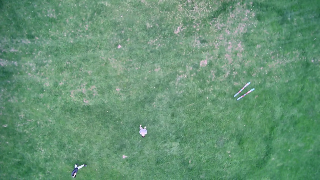

In [25]:
# The loop that "subscribes" to `gps_queue` and `image_queue`
while True:
  # Grab newest GPS and image filepath
  gps = None
  img_path = None

  # We subscribe to gps_queue and image_queue
  if not gps_queue.empty() and not image_queue.empty():
    gps = gps_queue.get()
    img_path = image_queue.get()

    # Build the initial prophecy
    prophecy = SauronProphecy(
      image_path=img_path,
      in_bounds=True,
      gps=gps
    )

    # Run the Sauron computer vision pipeline on the prophecy
    results = run_sauron(prophecy)

    print("Finished pipeline step.")

    # In production codebase, this is a publisher socket which publishes the generated `SauronResult`
    print(f"Sending `List[SauronResult]` to GNC... (pretend like this sends the following to GNC):")

    # Display out what we send:
    if results:
      for detection in results[0].detections:
        print(f" -> Detections: {model.names[detection.class_index]}")
    for result in results:
      print(f" -> GPS: {vars(result.target_gps)}")
    cv2_imshow(cv2.resize(cv2.imread(img_path), (0, 0), fx=0.25, fy=0.25))

    # 2 newlines
    print("\n\n", end="")

  # Poll every 100ms
  time.sleep(0.1)

  break